In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from tqdm import tqdm
%cd ..
from graphs import generate_full_report, perform_profit_factor_permutation_test
from utils import MARKET_TZ, is_market_open, calculate_profit_factor, calculate_regulatory_fees
%cd 1m_second

f:\Coding\Trading
f:\Coding\Trading\1m_second


In [2]:
def calculate_vwap(data):
    """
    Calculate intraday VWAP for each day.
    VWAP = cumulative (Typical Price * Volume) / cumulative Volume for the day
    """
    data = data.copy()
    data['Date'] = data.index.date
    data[['High', 'Low', 'Close', 'Volume']] = data[['High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric)
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    data['TPV'] = typical_price * data['Volume']
    data['Cumul_TPV'] = data.groupby('Date')['TPV'].cumsum()
    data['Cumul_Vol'] = data.groupby('Date')['Volume'].cumsum()
    data['VWAP'] = data['Cumul_TPV'] / data['Cumul_Vol']
    return data

def calculate_atr(data, period=14):
    high_low = data['High'] - data['Low']
    high_close = abs(data['High'] - data['Close'].shift())
    low_close = abs(data['Low'] - data['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(period).mean().bfill()
    return atr

def apply_strategy(data):
    """Apply the HedgeScalp strategy with improved implementation."""
    if len(data) < 20:
        return pd.DataFrame()
        
    try:
        data = calculate_vwap(data)
        data['Vol_MA'] = data['Volume'].rolling(window=30, min_periods=30).mean().ffill()
        data['EMA_7'] = data['Close'].ewm(span=14, adjust=False).mean()
        data['ATR'] = calculate_atr(data)
        
        # Handle potential NaN values
        data = data.ffill().bfill()
        
        # Dynamic threshold with smoothing
        threshold = 1.5 * (data['ATR'] / data['Close']).rolling(14).mean()
        
        # Long Signal with relaxed conditions
        data['LongSignal'] = (
            (data['Close'] < data['VWAP'] * (1 - threshold)) & 
            (data['Volume'] < data['Vol_MA'] * 0.9) &
            (data['Close'] > data['EMA_7']) &
            (data['Volume'] > 100)
        )

        # Short Signal with relaxed conditions
        data['ShortSignal'] = (
            (data['Close'] > data['VWAP'] * (1 + threshold)) & 
            (data['Volume'] < data['Vol_MA'] * 0.9) &
            (data['Close'] < data['EMA_7']) &
            (data['Volume'] > 100)
        )
        
        # Create unified signal column
        data['Signal'] = 0
        data.loc[data['LongSignal'], 'Signal'] = 1
        data.loc[data['ShortSignal'], 'Signal'] = -1
        
        return data.dropna()
        
    except Exception as e:
        print(f"Strategy error: {e}")
        return pd.DataFrame()

In [3]:
def get_historical_data(ticker, start_date, end_date):
    """
    Retrieve historical data from local storage or download new data and append.
    Returns timezone-aware DataFrame in MARKET_TZ.
    """
    os.makedirs('historical_data', exist_ok=True)
    file_path = f'historical_data/{ticker}.csv'
    
    # Convert input dates to timezone-aware datetime objects
    start_date = pd.to_datetime(start_date).tz_localize(MARKET_TZ)
    end_date = pd.to_datetime(end_date).tz_localize(MARKET_TZ)
    
    try:
        # Load existing data if available
        if os.path.exists(file_path):
            existing_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
            existing_data.index = existing_data.index.tz_localize(MARKET_TZ)
            last_date = existing_data.index.max()
        else:
            existing_data = pd.DataFrame()
            last_date = None
        
        # Determine date range needed
        download_start = last_date + timedelta(minutes=1) if last_date else start_date
        download_end = end_date
        
        # Only download if needed
        if not last_date or download_start < download_end:
            # Download new data
            new_data = yf.download(ticker, 
                                 start=download_start.tz_localize(None), 
                                 end=download_end.tz_localize(None),
                                 interval='1m')
            
            if not new_data.empty:
                # If data has multiple column levels, reduce to a single level.
                if isinstance(new_data.columns, pd.MultiIndex):
                    new_data.columns = new_data.columns.get_level_values(0)
                    
                # Convert index to market timezone
                new_data.index = new_data.index.tz_convert(MARKET_TZ)
                
                # Combine with existing data
                combined_data = pd.concat([existing_data, new_data])
                # Remove duplicates keeping last entry
                combined_data = combined_data[~combined_data.index.duplicated(keep='last')]
                combined_data.sort_index(inplace=True)
                
                # Save with naive timestamp
                combined_data_naive = combined_data.copy()
                combined_data_naive.index = combined_data_naive.index.tz_localize(None)
                combined_data_naive.to_csv(file_path)
            else:
                combined_data = existing_data
        else:
            combined_data = existing_data
        
        # Filter for requested date range
        filtered_data = combined_data.loc[start_date:end_date]
        return filtered_data
    
    except Exception as e:
        print(f"Error loading data for {ticker}: {e}")
        return pd.DataFrame()

In [4]:
def run_backtest(tickers, start_date, end_date, use_trailing_stop=True, exit_bars=60):
    """
    Run a backtest of the HedgeScalp strategy on multiple stocks
    
    Parameters:
    - tickers: List of stock symbols
    - start_date: Starting date for backtest
    - end_date: Ending date for backtest
    - use_trailing_stop: Whether to use trailing stops
    - exit_bars: Number of bars (minutes) before time-based exit
    
    Returns:
    - DataFrame of all trades and performance metrics
    """
    all_trades = []
    trade_logs = {}
    
    pbar = tqdm(tickers, desc="Processing Stocks")
    for ticker in pbar:
        pbar.set_description(f"Processing {ticker}")
        try:
            data = get_historical_data(ticker, start_date, end_date)
            if data.empty:
                continue
            
            # Apply HedgeScalp strategy to generate signals.
            data = apply_strategy(data)
            
            # Skip if no signals were generated.
            if 'Signal' not in data.columns or data['Signal'].abs().sum() == 0:
                continue
            
            # Initialize tracking for this ticker
            active_trades = {}
            ticker_trades = []
            
            # Process day by day
            for day, day_data in data.groupby(data.index.date):
                # Track VWAP components for this day
                cumul_tpv = 0
                cumul_vol = 0
                
                # Process each bar (minute) during the day
                for t, row in day_data.iterrows():
                    # Update VWAP for this bar
                    tp = (row['High'] + row['Low'] + row['Close']) / 3
                    cumul_tpv += tp * row['Volume']
                    cumul_vol += row['Volume']
                    
                    vwap = cumul_tpv / cumul_vol if cumul_vol > 0 else row['Close']
                    
                    # Check trailing stops for active trades
                    trades_to_close = []
                    for entry_time, trade in active_trades.items():
                        if use_trailing_stop:
                            # For long positions, trailing stop is previous candle's close
                            if trade['Direction'] == 'Long':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Close'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop > trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['Low'] <= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                            
                            # For short positions, trailing stop is previous candle's open
                            elif trade['Direction'] == 'Short':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Open'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop < trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['High'] >= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                        
                        # Time-based exit (after exit_bars minutes)
                        time_passed = (t - entry_time).total_seconds() / 60
                        if time_passed >= exit_bars:
                            trade['Exit Price'] = row['Close']
                            trade['Exit Time'] = t
                            trade['Exit Reason'] = 'Time-based'
                            
                            if trade['Direction'] == 'Long':
                                ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                            else:
                                ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                
                            trade['Return'] = ret
                            trade['Return %'] = ret * 100
                            
                            ticker_trades.append(trade)
                            trades_to_close.append(entry_time)
                    
                    # Remove closed trades
                    for entry_time in trades_to_close:
                        del active_trades[entry_time]
                    
                    # Process new entry signals when not in a position
                    if t not in active_trades and row['Signal'] != 0:
                        direction = 'Long' if row['Signal'] == 1 else 'Short'

                        position_size = 1000  # $10,00 per trade
                        shares = position_size // row['Close']
                        
                        # Set initial trailing stop
                        initial_stop = None
                        prev_idx = day_data.index.get_loc(t) - 1 if t in day_data.index else -1
                        if prev_idx > 0:
                            if direction == 'Long':
                                initial_stop = day_data['Close'].iloc[prev_idx]
                            else:
                                initial_stop = day_data['Open'].iloc[prev_idx]

                        if direction == 'Short':
                            entry_fee = calculate_regulatory_fees(row['Close'], shares)
                            # Store fee to deduct from returns later
                            fee_impact = entry_fee / (row['Close'] * shares)
                        else:
                            fee_impact = 0
                        
                        active_trades[t] = {
                            'Symbol': ticker,
                            'DateTime': t,
                            'Direction': direction,
                            'Entry Price': row['Close'],
                            'Shares': shares,
                            'Fee Impact': fee_impact,
                            'Stop': initial_stop,
                            'VWAP': vwap,
                            'Volume': row['Volume'],
                            'Vol_MA': row['Vol_MA'],
                        }
                        
                        # print(f"{direction} {ticker} at {row['Close']:.2f} on {t} (RSI: {row['RSI']:.2f}, VWAP: {vwap:.2f})")
            
            # Close any remaining open trades at the end of data
            for entry_time, trade in active_trades.items():
                last_row = data.iloc[-1]
                trade['Exit Price'] = last_row['Close'] 
                trade['Exit Time'] = data.index[-1]
                trade['Exit Reason'] = 'End of Data'
                
                if trade['Direction'] == 'Long':
                    # Apply fees for long exits
                    exit_fee = calculate_regulatory_fees(trade['Exit Price'], trade['Shares'])
                    fee_impact = exit_fee / (trade['Entry Price'] * trade['Shares'])
                else:
                    fee_impact = trade['Fee Impact']  # Already accounted for at entry

                if trade['Direction'] == 'Long':
                    ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                else:
                    ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                    
                trade['Return'] = ret
                trade['Return %'] = ret * 100
                
                ticker_trades.append(trade)
            
            # Add ticker trades to overall results
            all_trades.extend(ticker_trades)
            
            # Store in trade logs for performance summary
            if ticker_trades:
                trade_logs[ticker] = [t['Return'] for t in ticker_trades]
                
                # Print performance for this ticker
                total_pnl = sum(trade_logs[ticker])
                num_trades = len(trade_logs[ticker])
                # print(f"{ticker}: Total PnL: {total_pnl:.4f} from {num_trades} trades")
                
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    # Create results dataframe 
    if all_trades:
        results = pd.DataFrame(all_trades)
        results.sort_values('DateTime', inplace=True)
        
        # Print overall performance summary
        print("\n=== Overall Performance Summary ===")
        print(f"Total Return: {results['Return'].sum():.4f} ({results['Return %'].sum():.2f}%)")
        print(f"Average Return per Trade: {results['Return'].mean():.4f} ({results['Return %'].mean():.2f}%)")
        print(f"Win Rate: {(results['Return'] > 0).mean():.2%}")
        print(f"Total Number of Trades: {len(results)}")
        
        # Print per-stock summary
        print("\n=== Per-stock Trade Performance Summary ===")
        for symbol, pnl_list in trade_logs.items():
            total_pnl = sum(pnl_list)
            num_trades = len(pnl_list)
            win_rate = sum(1 for pnl in pnl_list if pnl > 0) / num_trades if num_trades > 0 else 0
            print(f"{symbol}: Total PnL: {total_pnl:.4f} from {num_trades} trades (Win rate: {win_rate:.2%})")
        
        return results
    else:
        print("No trades were generated.")
        return pd.DataFrame()

In [5]:
tickers = [
    "MSTR", "CVNA", "COIN", "AFRM", "AR", "PR", "DJT", "MARA",
    "ACHR", "BE", "W", "SOUN", "SM", "RIOT", "CLSK", "BHVN",
    "JANX", "SEZL", "IREN"
]

# Run the backtest
def get_previous_trading_day(date):
    current_date = date
    while True:
        current_date -= timedelta(days=1)
        if is_market_open(current_date):
            return current_date

def get_next_trading_day(date):
    current_date = date
    while True:
        if is_market_open(current_date):
            return current_date
        current_date += timedelta(days=1)

today = datetime.now().date()
if not is_market_open(today):
    print(f"Market is closed ({today}). Adjusting to last trading day.")
    end_date = get_previous_trading_day(today)
    print(end_date)
else:
    end_date = today

start_date_candidate = end_date - timedelta(days=7)
start_date = get_next_trading_day(start_date_candidate)

# Ensure start_date is not after end_date
if start_date > end_date:
    start_date = end_date

# Run the backtest with corrected dates
results = run_backtest(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    use_trailing_stop=True,
    exit_bars=30
)

Processing MSTR:   0%|          | 0/19 [00:00<?, ?it/s]  

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSTR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-16 16:00:00 -> 2025-09-17 00:00:00)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVNA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-16 16:00:00 -> 2025-09-17 00:00:00)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COIN']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-16 16:00:00 -> 2025-09-17 00:00:00)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AFRM']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-09-16 16:00:00 -> 2025-09-17 00:00:00)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AR']: YFPricesMissingError('possibly delisted; no price data foun


=== Overall Performance Summary ===
Total Return: 2.0962 (209.62%)
Average Return per Trade: 0.0004 (0.04%)
Win Rate: 48.77%
Total Number of Trades: 4958

=== Per-stock Trade Performance Summary ===
MSTR: Total PnL: 0.0704 from 262 trades (Win rate: 49.62%)
CVNA: Total PnL: 0.1335 from 314 trades (Win rate: 57.64%)
COIN: Total PnL: 0.0807 from 260 trades (Win rate: 45.00%)
AFRM: Total PnL: 0.0926 from 309 trades (Win rate: 52.75%)
AR: Total PnL: 0.0896 from 259 trades (Win rate: 53.67%)
PR: Total PnL: 0.0172 from 234 trades (Win rate: 26.50%)
DJT: Total PnL: 0.0548 from 247 trades (Win rate: 45.34%)
MARA: Total PnL: 0.0825 from 218 trades (Win rate: 41.74%)
ACHR: Total PnL: 0.0658 from 297 trades (Win rate: 39.39%)
BE: Total PnL: 0.1589 from 335 trades (Win rate: 54.93%)
W: Total PnL: 0.1285 from 261 trades (Win rate: 59.00%)
SOUN: Total PnL: 0.1209 from 262 trades (Win rate: 46.18%)
SM: Total PnL: 0.1032 from 238 trades (Win rate: 57.98%)
RIOT: Total PnL: 0.1313 from 199 trades (Win 


PERFORMANCE REPORT


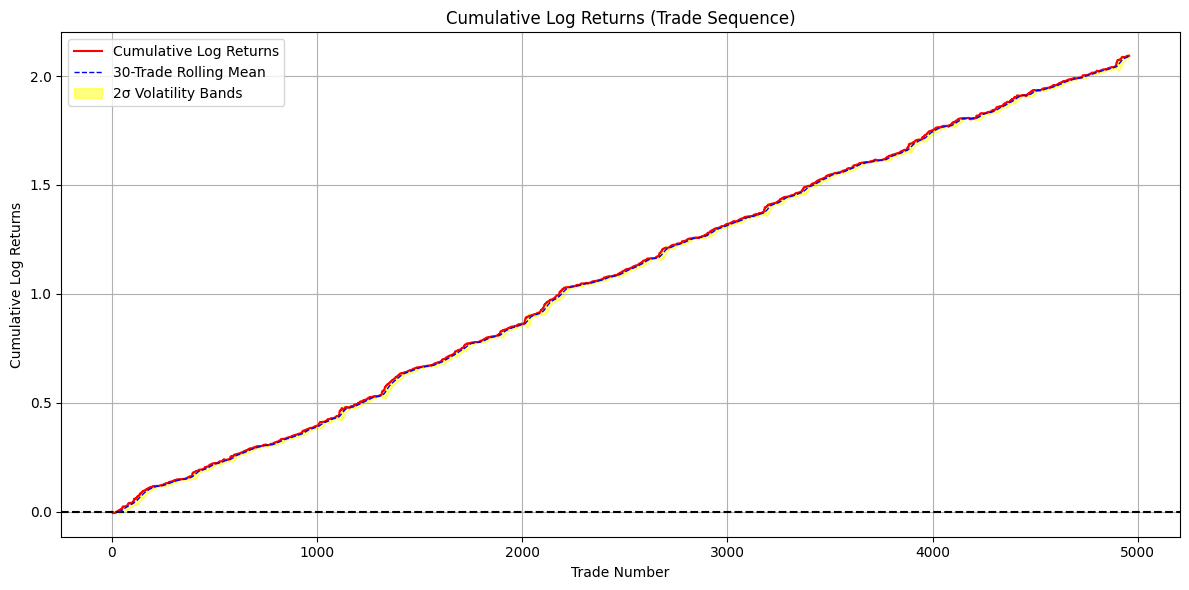

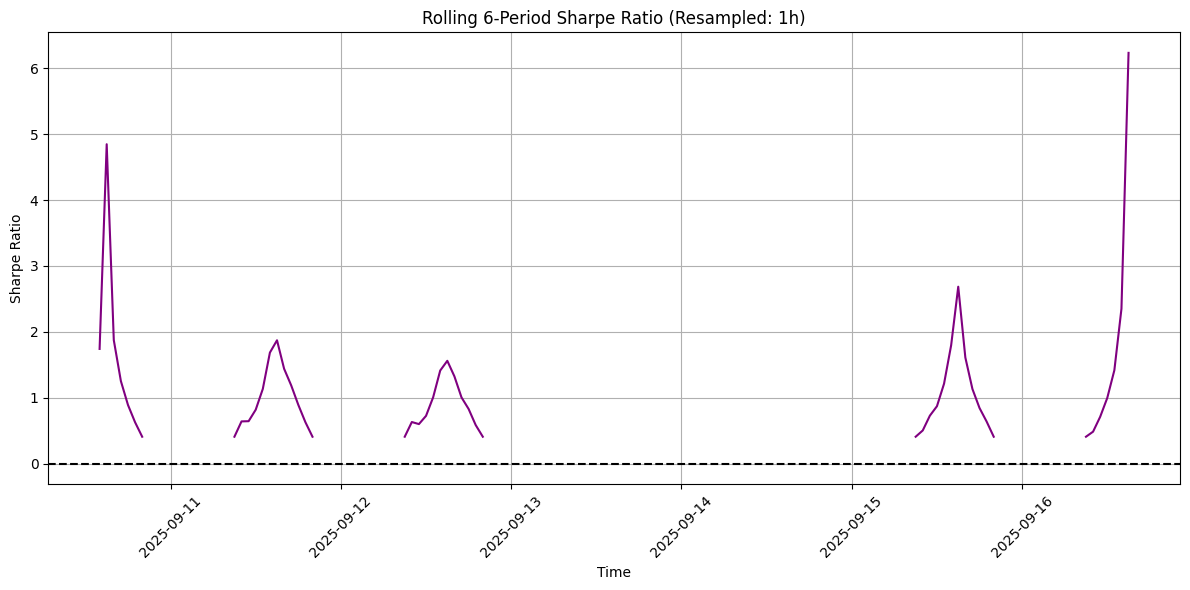

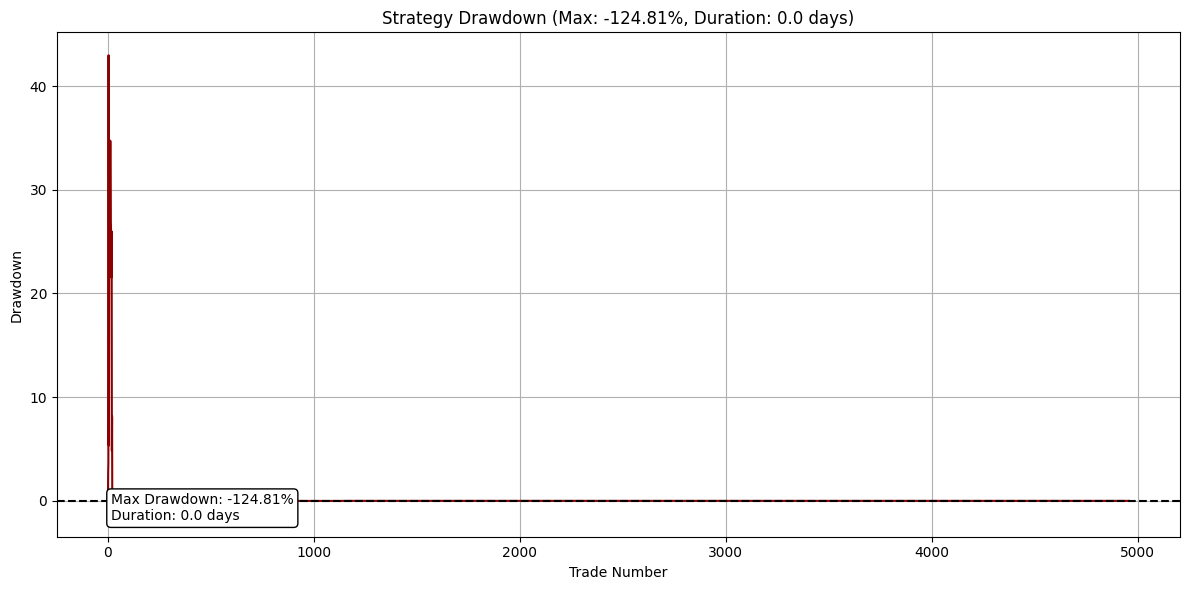


--- Return Statistics ---
count    4958.0000
mean        0.0004
std         0.0011
min        -0.0054
10%        -0.0003
25%         0.0000
50%         0.0000
75%         0.0006
90%         0.0015
99%         0.0047
99.9%       0.0091
99.99%      0.0128
max         0.0144

--- Worst Outcomes (Bottom 1.0%) ---
Worst 1.0000%: -0.0014
Worst 0.1000%: -0.0031
Worst 0.0100%: -0.0053


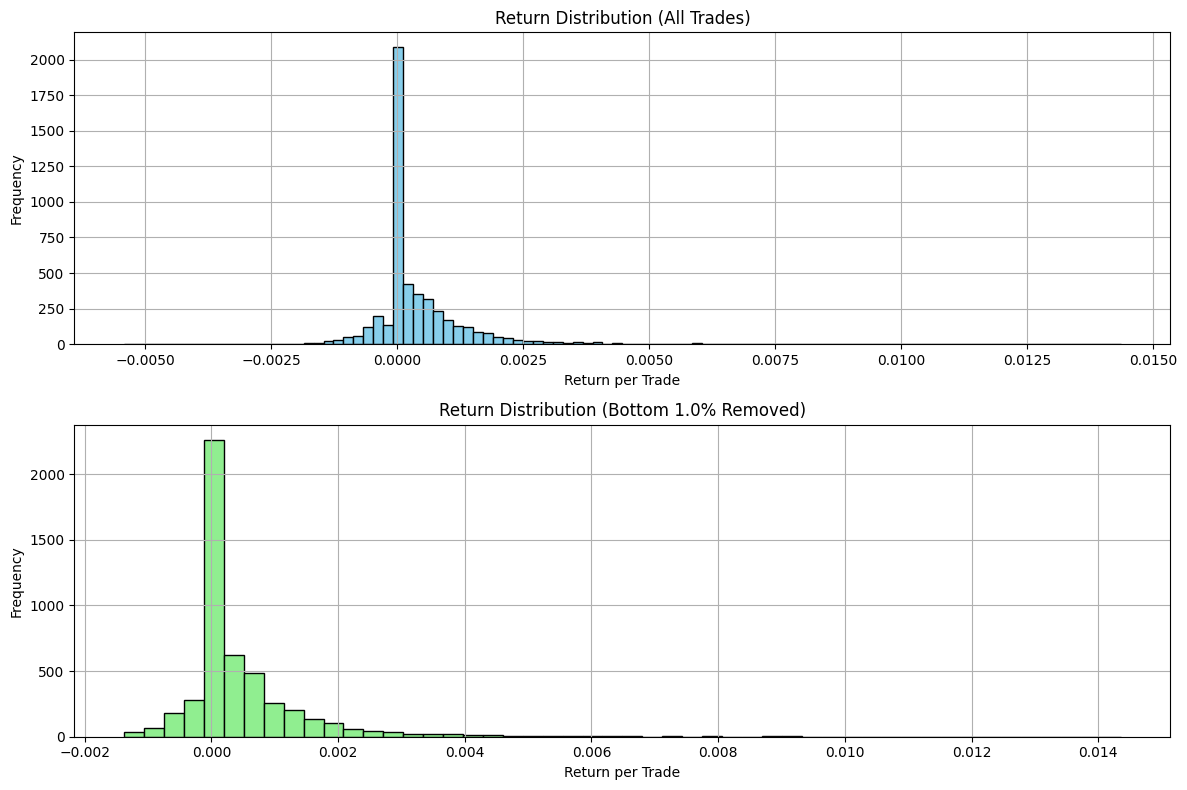

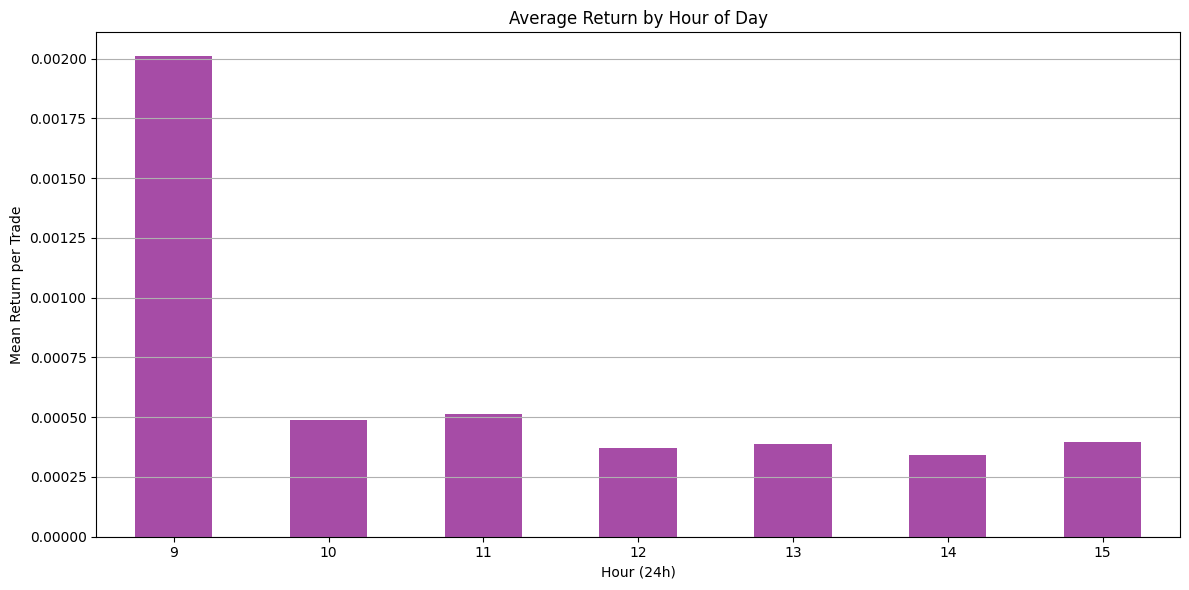


--- 1 Day Kelly Simulations ---

Kelly Fraction: 100%
count   5000.00
mean    1540.54
std       58.62
min     1347.74
1%      1413.74
10%     1466.15
25%     1500.77
50%     1539.05
75%     1578.13
90%     1616.50
99%     1685.52
max     1781.31


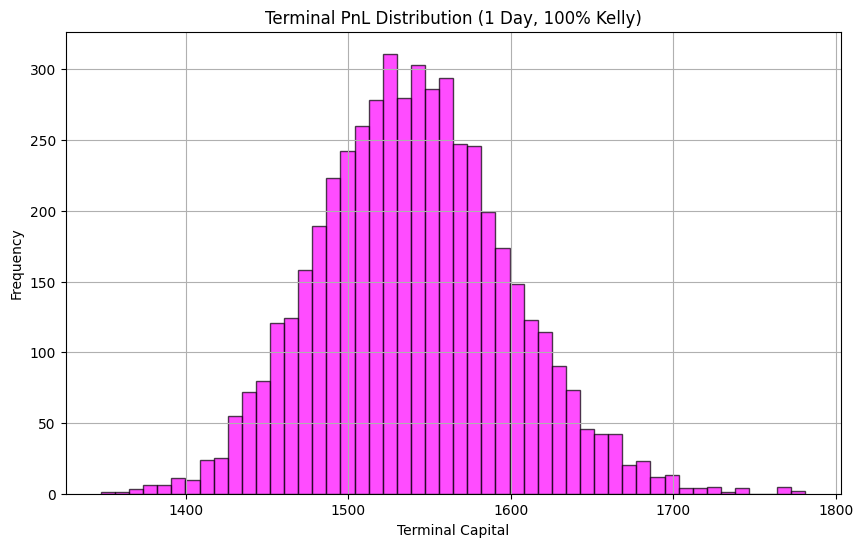

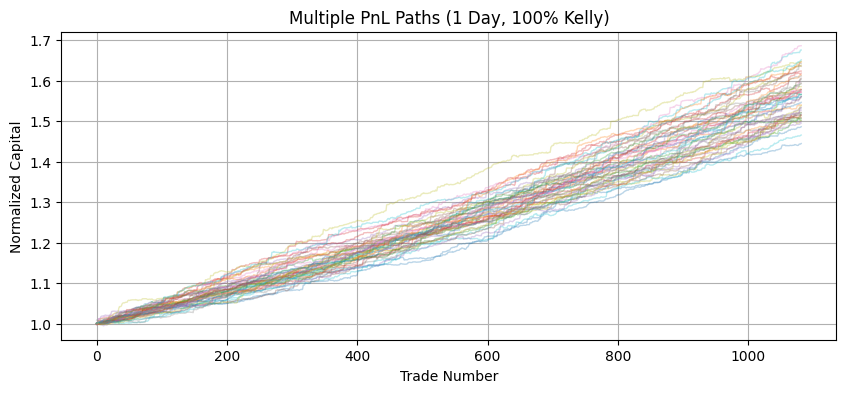


Kelly Fraction: 50%
count   5000.00
mean    1241.21
std       23.61
min     1161.11
1%      1189.22
10%     1211.05
25%     1225.28
50%     1240.84
75%     1256.50
90%     1271.70
99%     1298.60
max     1335.08


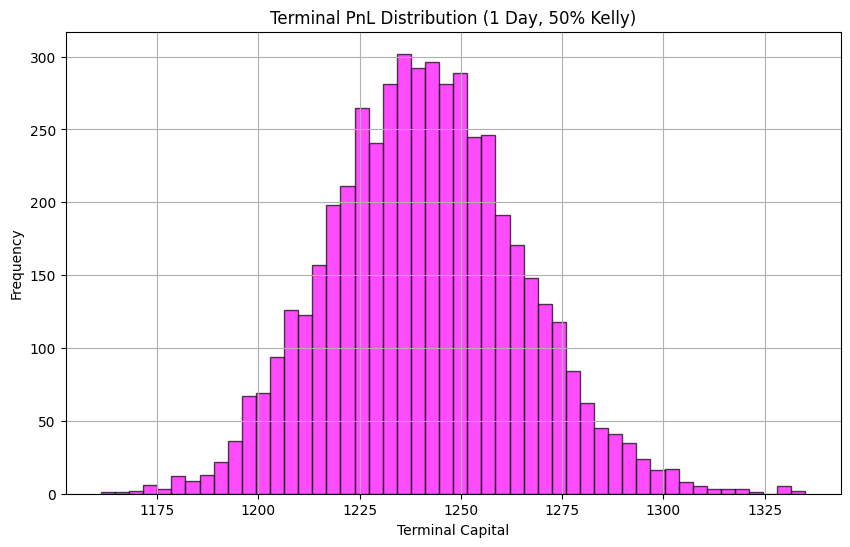

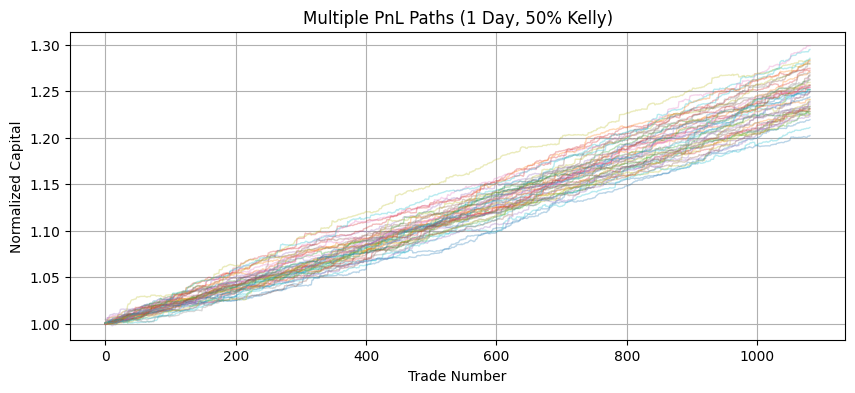


Kelly Fraction: 30%
count   5000.00
mean    1138.44
std       12.99
min     1093.80
1%      1109.62
10%     1121.80
25%     1129.70
50%     1138.28
75%     1146.89
90%     1155.20
99%     1169.80
max     1189.43


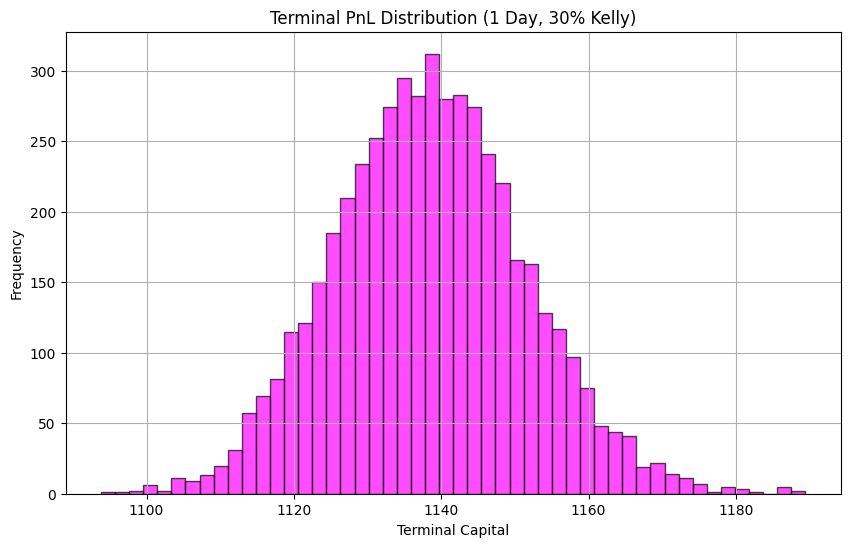

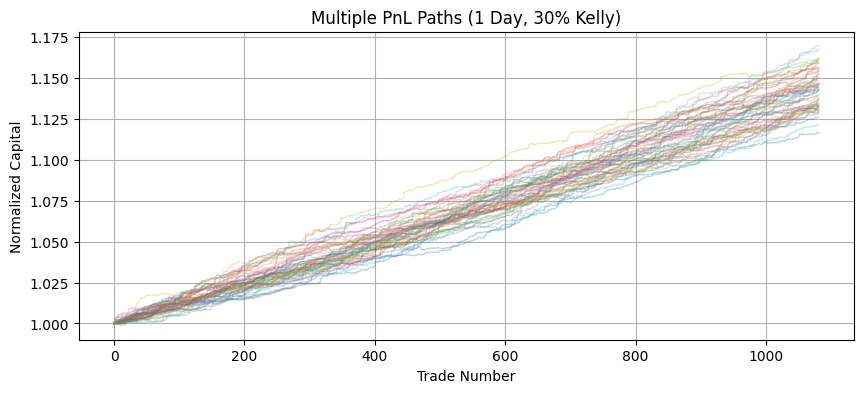


--- 3 Days Kelly Simulations ---

Kelly Fraction: 100%
count   5000.00
mean    2277.56
std      108.91
min     1957.77
1%      2045.44
10%     2140.33
25%     2201.85
50%     2272.92
75%     2348.47
90%     2419.22
99%     2555.63
max     2672.05


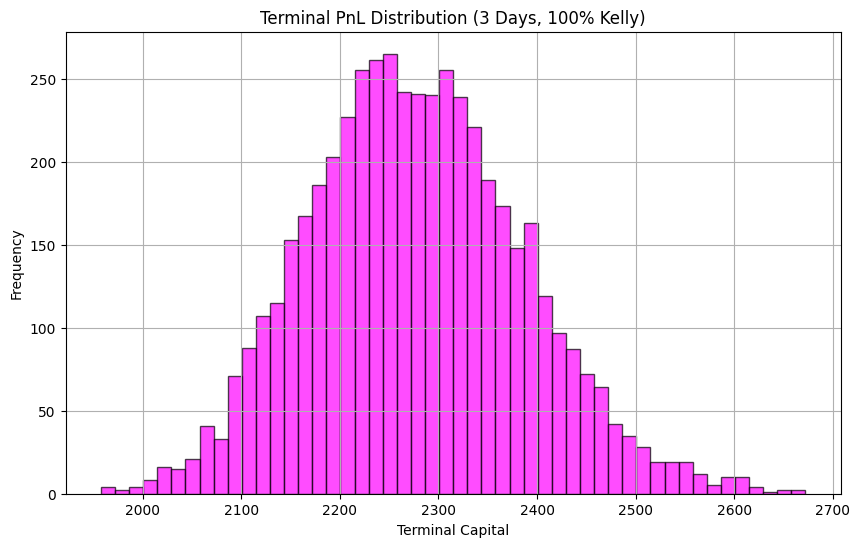

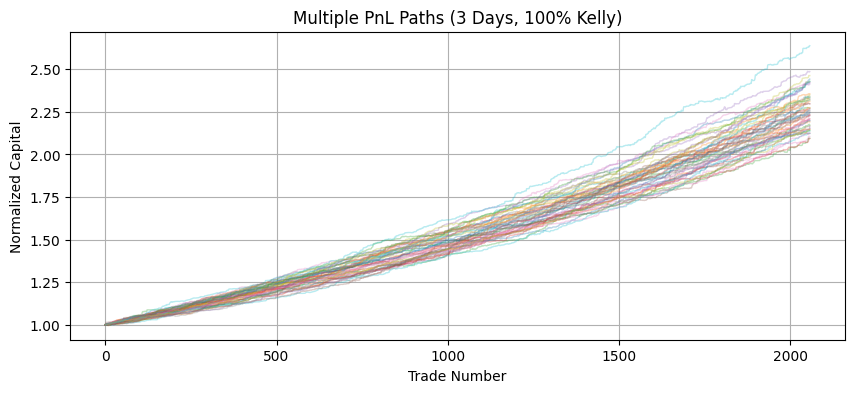


Kelly Fraction: 50%
count   5000.00
mean    1509.23
std       36.06
min     1399.55
1%      1430.62
10%     1463.44
25%     1484.33
50%     1508.12
75%     1532.99
90%     1555.97
99%     1599.26
max     1635.28


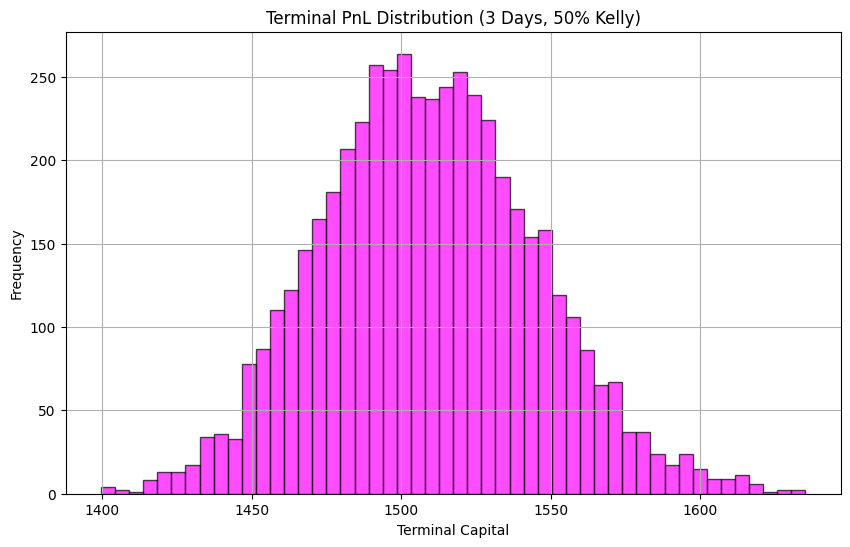

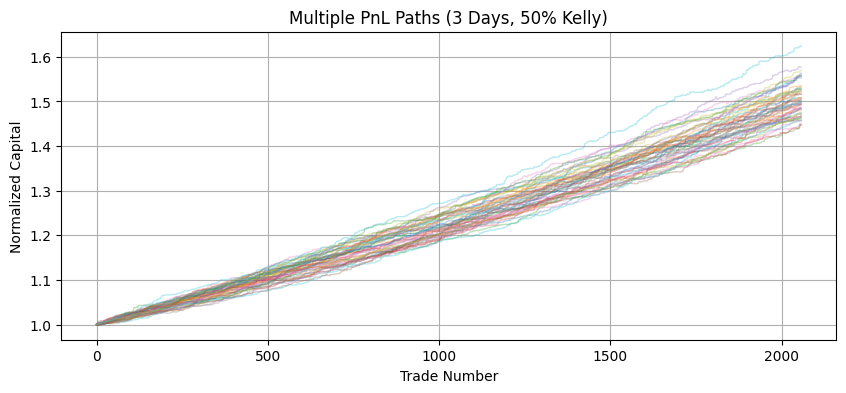


Kelly Fraction: 30%
count   5000.00
mean    1280.14
std       18.35
min     1223.54
1%      1239.78
10%     1256.77
25%     1267.52
50%     1279.66
75%     1292.29
90%     1303.89
99%     1325.54
max     1343.37


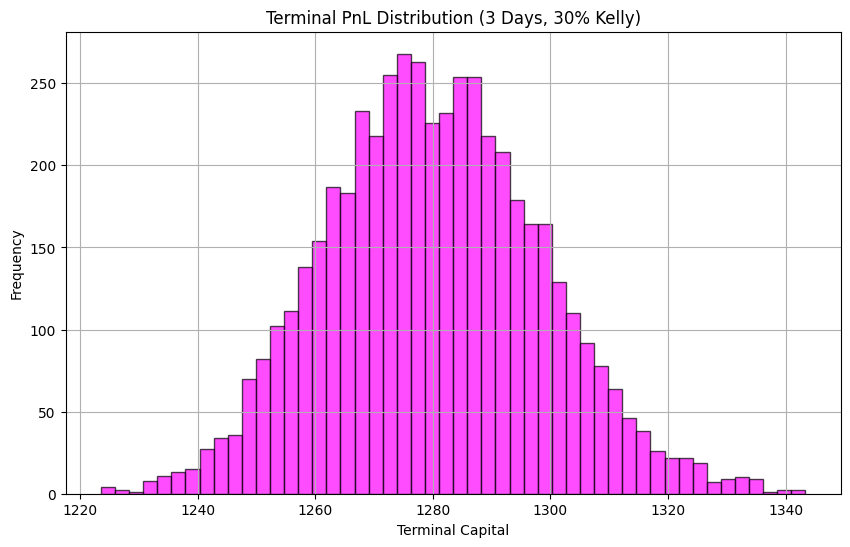

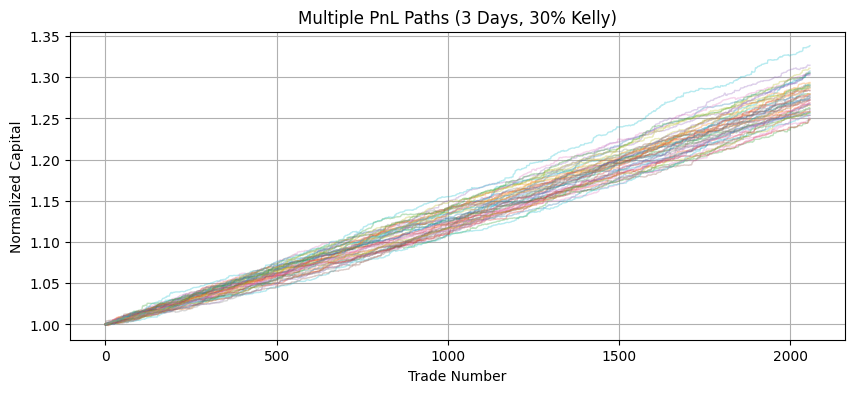


--- 1 Week Kelly Simulations ---

Kelly Fraction: 100%
count    5000.00
mean     8137.43
std       627.26
min      6221.85
1%       6807.45
10%      7332.87
25%      7707.23
50%      8109.07
75%      8542.99
90%      8971.32
99%      9725.07
max     10848.01


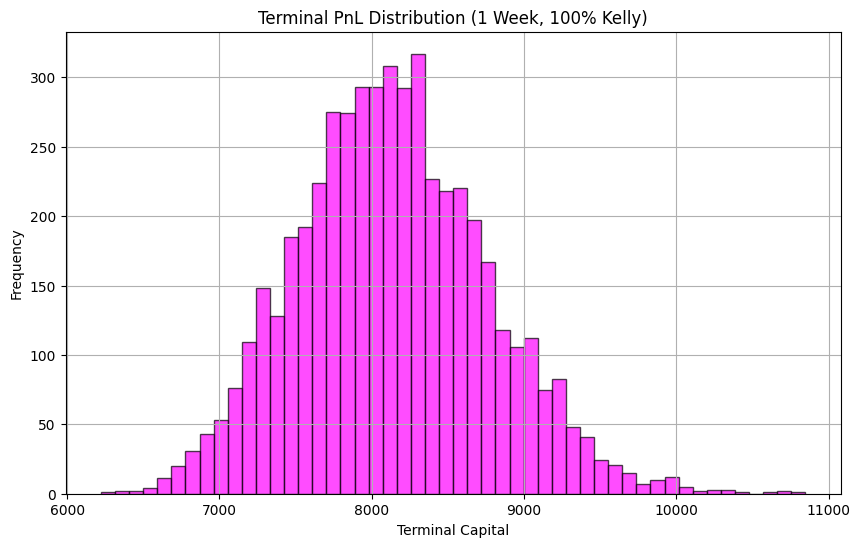

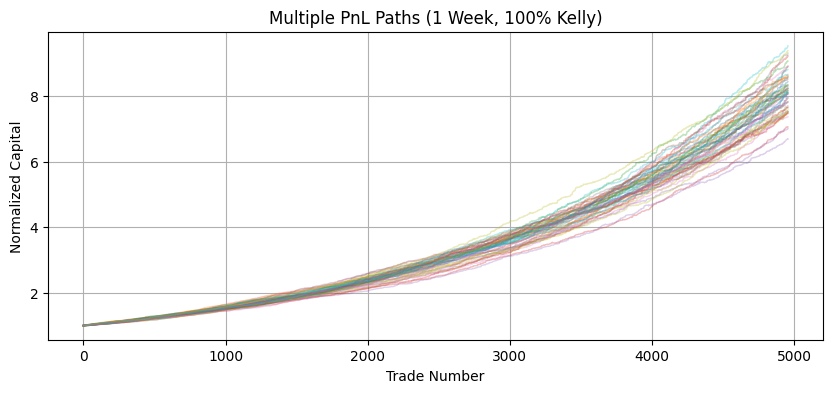


Kelly Fraction: 50%
count   5000.00
mean    2852.89
std      109.84
min     2496.05
1%      2611.19
10%     2710.03
25%     2778.46
50%     2850.01
75%     2925.37
90%     2997.88
99%     3121.40
max     3297.25


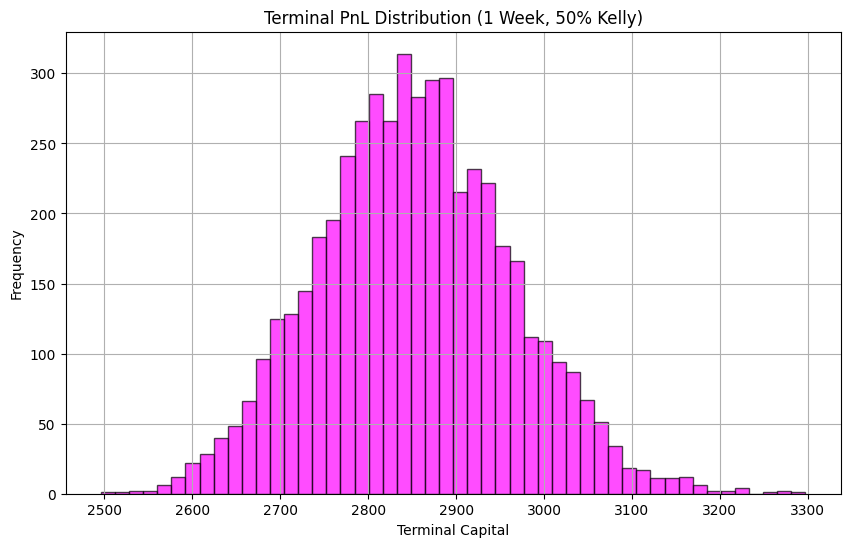

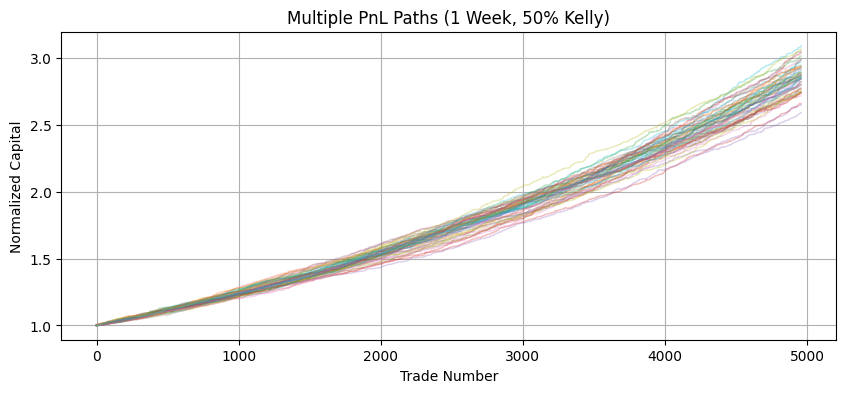


Kelly Fraction: 30%
count   5000.00
mean    1875.77
std       43.32
min     1731.50
1%      1779.04
10%     1819.14
25%     1846.57
50%     1874.97
75%     1904.56
90%     1932.78
99%     1980.19
max     2046.47


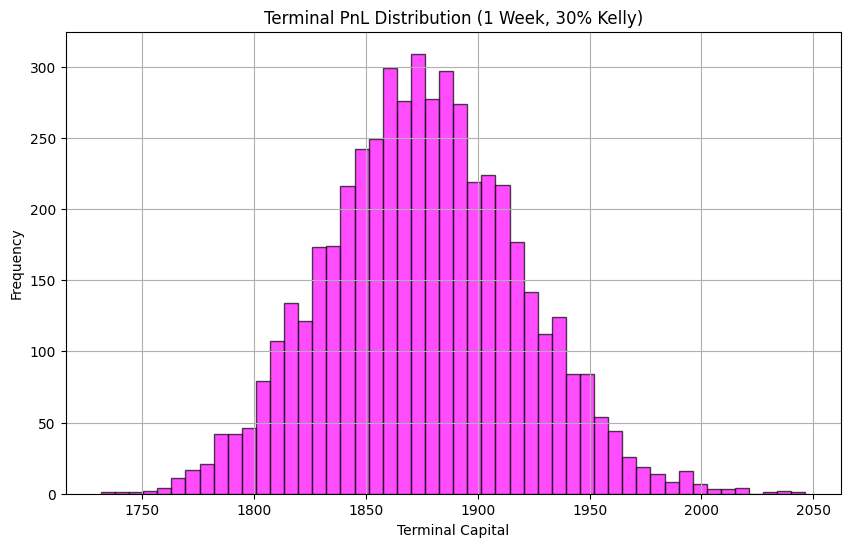

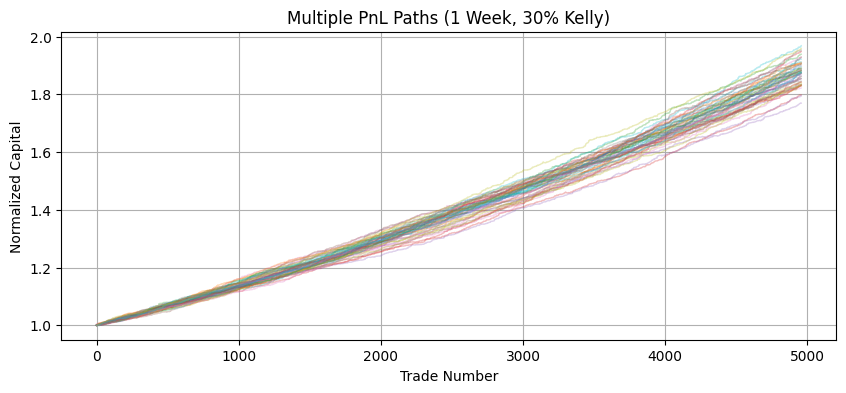


--- Full Dataset Kelly Simulations ---

Kelly Fraction: 100%
count    5000.00
mean     8137.43
std       627.26
min      6221.85
1%       6807.45
10%      7332.87
25%      7707.23
50%      8109.07
75%      8542.99
90%      8971.32
99%      9725.07
max     10848.01


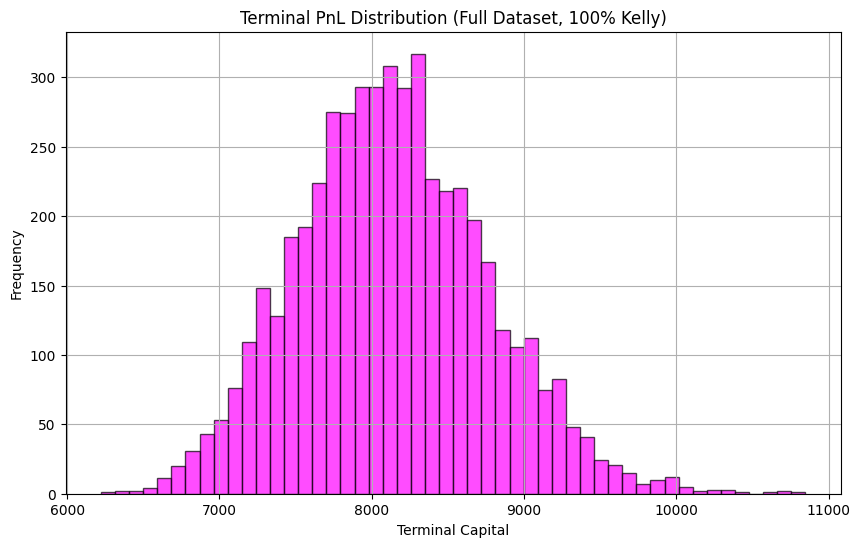

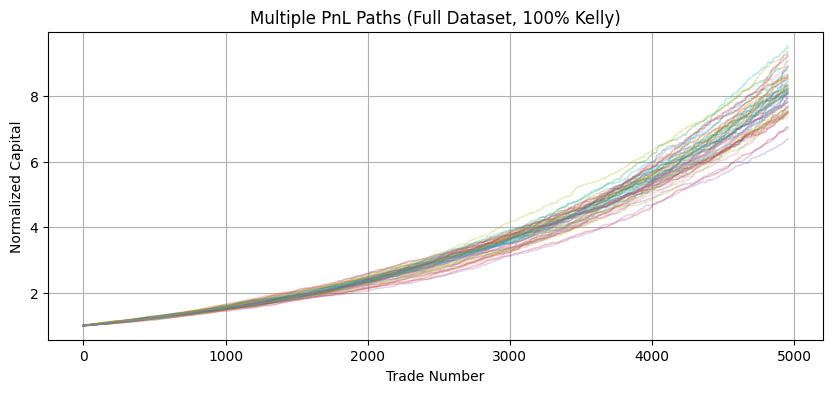


Kelly Fraction: 50%
count   5000.00
mean    2852.89
std      109.84
min     2496.05
1%      2611.19
10%     2710.03
25%     2778.46
50%     2850.01
75%     2925.37
90%     2997.88
99%     3121.40
max     3297.25


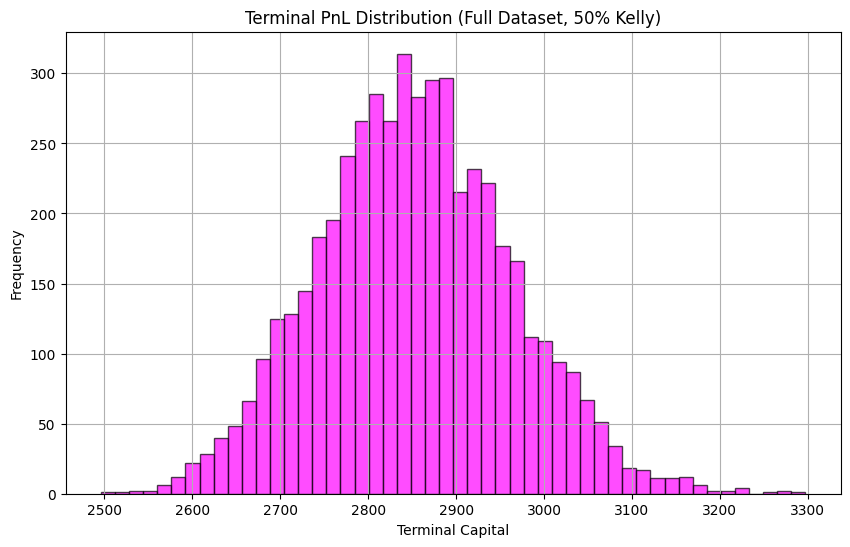

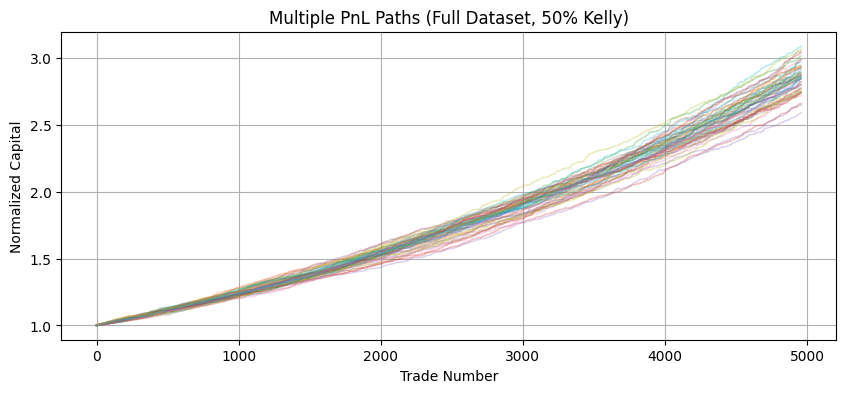


Kelly Fraction: 30%
count   5000.00
mean    1875.77
std       43.32
min     1731.50
1%      1779.04
10%     1819.14
25%     1846.57
50%     1874.97
75%     1904.56
90%     1932.78
99%     1980.19
max     2046.47


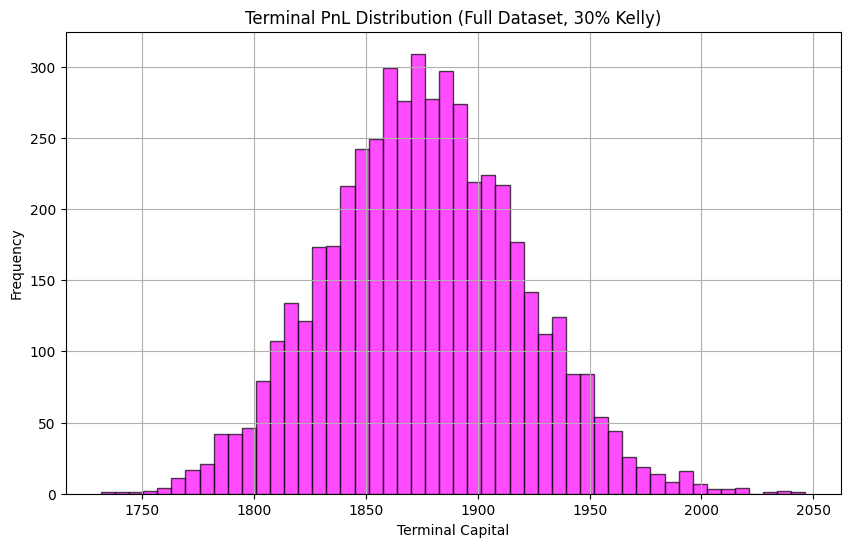

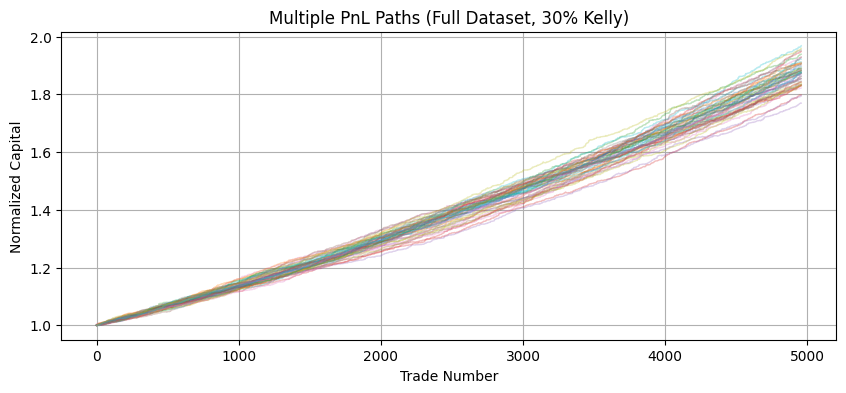

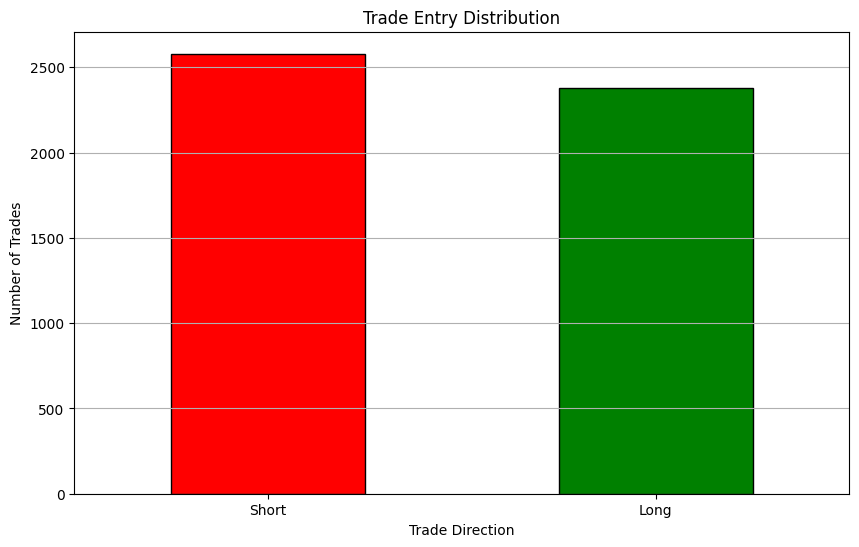

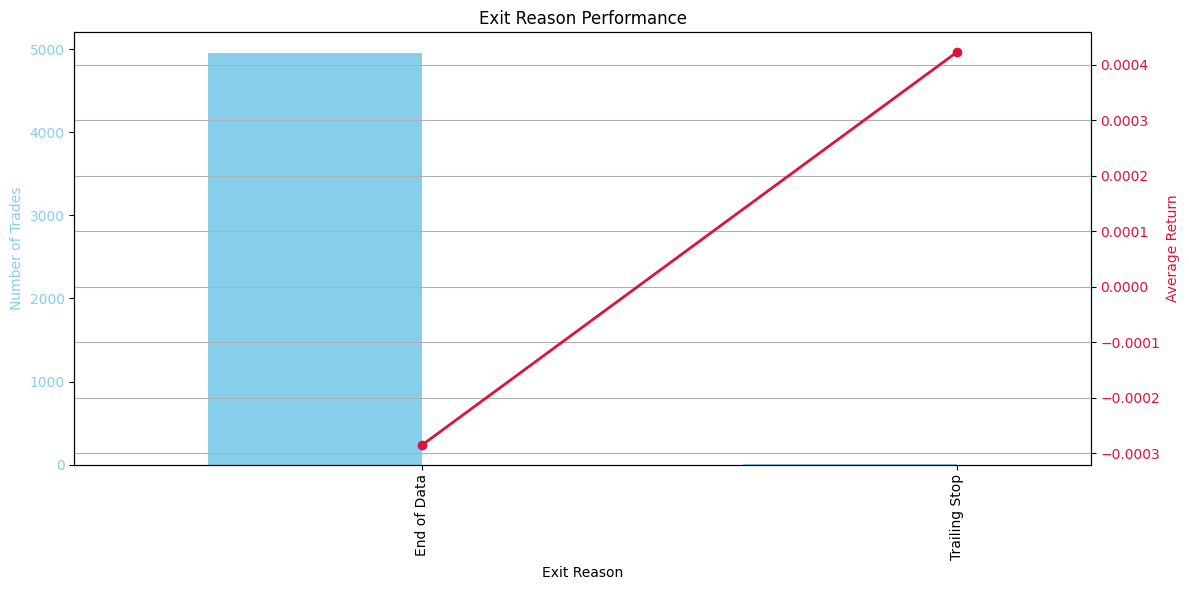


--- Trade Direction Summary ---
Direction
Short    2580
Long     2378

--- Exit Reason Performance ---
              Count Avg Return
Exit Reason                   
End of Data       2    -0.0003
Trailing Stop  4956     0.0004

END OF REPORT


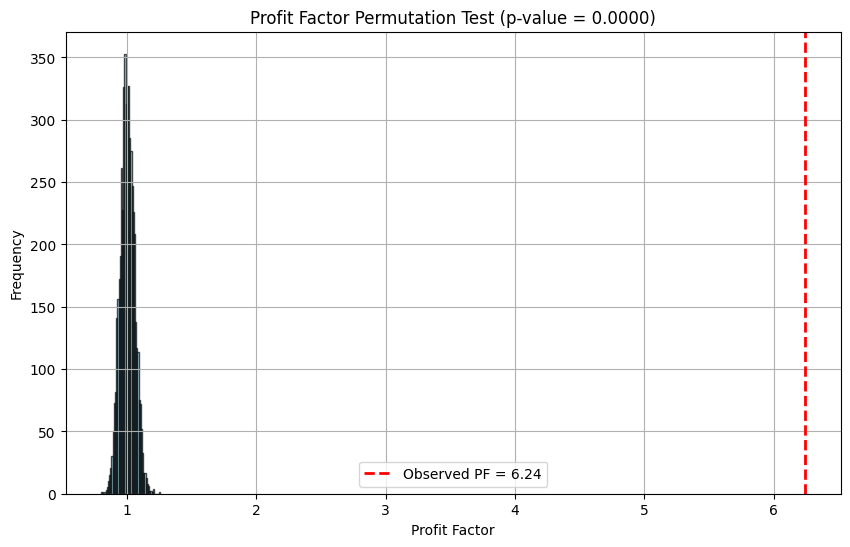


=== Profit Factor Permutation Test ===
Observed Profit Factor: 6.2440
Mean Permutation Profit Factor: 1.0019
P-value: 0.0000
Result: The observed profit factor is statistically significant (p < 0.05)

Final Profit Factor Permutation Test p-value: 0.0000


In [6]:
if not results.empty:
    generate_full_report(results)
    p_value = perform_profit_factor_permutation_test(results['Return'].values, n_permutations=5000)
    print(f"\nFinal Profit Factor Permutation Test p-value: {p_value:.4f}")
else:
    print("No trades found with the given strategy.")

In [7]:
def run_walkforward_analysis(tickers, start_date, end_date, use_trailing_stop=True, exit_bars=60):
    """
    Run walk-forward analysis of the HedgeScalp strategy
    
    Parameters:
    - tickers: List of stock symbols
    - start_date: Starting date for backtest
    - end_date: Ending date for backtest
    - use_trailing_stop: Whether to use trailing stops
    - exit_bars: Number of bars (minutes) before time-based exit
    
    Returns:
    - DataFrame of all out-of-sample trades
    """
    # Convert dates to datetime if they're strings
    if not isinstance(start_date, datetime):
        start_date = datetime.combine(start_date, datetime.min.time())
    if not isinstance(end_date, datetime):
        end_date = datetime.combine(end_date, datetime.min.time())
    
    # For 7 days of data: use 5 days for training, 2 days for testing
    train_start = start_date
    train_end = start_date + timedelta(days=5)
    test_start = train_end
    test_end = end_date
    
    print(f"\n=== Processing Walk-Forward Window ===")
    print(f"Training: {train_start.strftime('%Y-%m-%d')} to {train_end.strftime('%Y-%m-%d')}")
    print(f"Testing:  {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}")
    
    # Start storing results
    all_oos_trades = []
    
    # Process each ticker
    for ticker in tqdm(tickers, desc="Processing Tickers"):
        try:
            data = get_historical_data(ticker, train_start - timedelta(days=1),
                                        test_end + timedelta(days=1))
            
            if data.empty:
                continue
            
            # Convert timezone-aware index to naive for comparison
            data.index = data.index.tz_localize(None)
            
            # Split into train and test sets
            train_data = data[data.index < train_end]
            test_data = data[(data.index >= test_start) & (data.index < test_end)]
            
            if train_data.empty or test_data.empty:
                continue
            
            # Apply strategy to training data (for analysis only)
            train_data = apply_strategy(train_data)
            
            # Apply strategy to the test data
            test_data = apply_strategy(test_data)
            
            # Skip if no signals were generated in test set
            if 'Signal' not in test_data.columns or test_data['Signal'].abs().sum() == 0:
                continue
            
            # Initialize tracking for this ticker
            active_trades = {}
            ticker_trades = []
            
            # Process day by day in test data
            for day, day_data in test_data.groupby(test_data.index.date):
                # Track VWAP components for this day
                cumul_tpv = 0
                cumul_vol = 0
                
                # Process each bar (minute) during the day
                for t, row in day_data.iterrows():
                    # Update VWAP for this bar
                    tp = (row['High'] + row['Low'] + row['Close']) / 3
                    cumul_tpv += tp * row['Volume']
                    cumul_vol += row['Volume']
                    
                    vwap = cumul_tpv / cumul_vol if cumul_vol > 0 else row['Close']
                    
                    # Check trailing stops for active trades
                    trades_to_close = []
                    for entry_time, trade in active_trades.items():
                        if use_trailing_stop:
                            # For long positions, trailing stop is previous candle's close
                            if trade['Direction'] == 'Long':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Close'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop > trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['Low'] <= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                            
                            # For short positions, trailing stop is previous candle's open
                            elif trade['Direction'] == 'Short':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Open'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop < trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['High'] >= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                        
                        # Time-based exit (after exit_bars minutes)
                        time_passed = (t - entry_time).total_seconds() / 60
                        if time_passed >= exit_bars:
                            trade['Exit Price'] = row['Close']
                            trade['Exit Time'] = t
                            trade['Exit Reason'] = 'Time-based'
                            
                            if trade['Direction'] == 'Long':
                                ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                            else:
                                ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                
                            trade['Return'] = ret
                            trade['Return %'] = ret * 100
                            
                            ticker_trades.append(trade)
                            trades_to_close.append(entry_time)
                    
                    # Remove closed trades
                    for entry_time in trades_to_close:
                        del active_trades[entry_time]
                    
                    # Process new entry signals when not in a position
                    if len(active_trades) == 0 and row['Signal'] != 0:
                        direction = 'Long' if row['Signal'] == 1 else 'Short'

                        position_size = 1000  # $10,000 per trade
                        shares = position_size // row['Close']
                        
                        # Set initial trailing stop
                        initial_stop = None
                        prev_idx = day_data.index.get_loc(t) - 1 if t in day_data.index else -1
                        if prev_idx > 0:
                            if direction == 'Long':
                                initial_stop = day_data['Close'].iloc[prev_idx]
                            else:
                                initial_stop = day_data['Open'].iloc[prev_idx]

                        if direction == 'Short':
                            entry_fee = calculate_regulatory_fees(row['Close'], shares)
                            # Store fee to deduct from returns later
                            fee_impact = entry_fee / (row['Close'] * shares)
                        else:
                            fee_impact = 0
                        
                        active_trades[t] = {
                            'Symbol': ticker,
                            'DateTime': t,
                            'Direction': direction,
                            'Entry Price': row['Close'],
                            'Shares': shares,
                            'Fee Impact': fee_impact,
                            'Stop': initial_stop,
                            'VWAP': vwap,
                            'Volume': row['Volume'],
                            'Vol_MA': row['Vol_MA']
                        }
            
            # Close any remaining open trades at the end of data
            for entry_time, trade in active_trades.items():
                last_row = test_data.iloc[-1]
                trade['Exit Price'] = last_row['Close'] 
                trade['Exit Time'] = test_data.index[-1]
                trade['Exit Reason'] = 'End of Data'

                if trade['Direction'] == 'Long':
                    # Apply fees for long exits
                    exit_fee = calculate_regulatory_fees(trade['Exit Price'], trade['Shares'])
                    fee_impact = exit_fee / (trade['Entry Price'] * trade['Shares'])
                else:
                    fee_impact = trade['Fee Impact']
                
                if trade['Direction'] == 'Long':
                    ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                else:
                    ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                    
                trade['Return'] = ret
                trade['Return %'] = ret * 100
                
                ticker_trades.append(trade)
            
            # Add ticker trades to overall out-of-sample results
            all_oos_trades.extend(ticker_trades)
            
            # Print ticker performance summary
            if ticker_trades:
                ticker_returns = [t['Return'] for t in ticker_trades]
                total_pnl = sum(ticker_returns)
                num_trades = len(ticker_returns)
                win_rate = sum(1 for r in ticker_returns if r > 0) / num_trades if num_trades > 0 else 0
                profit_factor = calculate_profit_factor(np.array(ticker_returns))
                
                print(f"{ticker}: Total PnL: {total_pnl:.4f} from {num_trades} trades (Win rate: {win_rate:.2%}, Profit Factor: {profit_factor:.2f})")
            
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    # Create results dataframe
    if all_oos_trades:
        oos_results = pd.DataFrame(all_oos_trades)
        
        # Print overall out-of-sample performance summary
        print("\n=== Overall Out-of-Sample Performance Summary ===")
        total_return = oos_results['Return'].sum()
        avg_return = oos_results['Return'].mean()
        win_rate = (oos_results['Return'] > 0).mean()
        profit_factor = calculate_profit_factor(oos_results['Return'].values)
        
        print(f"Total Return: {total_return:.4f} ({oos_results['Return %'].sum():.2f}%)")
        print(f"Average Return per Trade: {avg_return:.4f} ({oos_results['Return %'].mean():.2f}%)")
        print(f"Win Rate: {win_rate:.2%}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Total Number of Trades: {len(oos_results)}")
        
        # Perform Monte Carlo analysis on OOS returns
        profit_factor_pvalue = perform_profit_factor_permutation_test(oos_results['Return'].values)
        
        return oos_results, profit_factor_pvalue
    else:
        print("No trades were generated in the out-of-sample period.")
        return pd.DataFrame(), None


=== Processing Walk-Forward Window ===
Training: 2025-09-10 to 2025-09-15
Testing:  2025-09-15 to 2025-09-17


[*********************100%***********************]  1 of 1 completed
Processing Tickers:   5%|▌         | 1/19 [00:00<00:06,  2.67it/s]

MSTR: Total PnL: 0.0392 from 118 trades (Win rate: 53.39%, Profit Factor: 4.92)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

CVNA: Total PnL: 0.0438 from 90 trades (Win rate: 68.89%, Profit Factor: 8.68)



[*********************100%***********************]  1 of 1 completed

COIN: Total PnL: 0.0279 from 72 trades (Win rate: 47.22%, Profit Factor: 19.02)



[*********************100%***********************]  1 of 1 completed

AFRM: Total PnL: 0.0335 from 111 trades (Win rate: 62.16%, Profit Factor: 3.06)



Processing Tickers:  26%|██▋       | 5/19 [00:01<00:04,  3.46it/s]

AR: Total PnL: 0.0301 from 83 trades (Win rate: 54.22%, Profit Factor: 10.65)


[*********************100%***********************]  1 of 1 completed
Processing Tickers:  32%|███▏      | 6/19 [00:01<00:03,  3.44it/s]

PR: Total PnL: 0.0113 from 87 trades (Win rate: 36.78%, Profit Factor: 2.27)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

DJT: Total PnL: 0.0226 from 96 trades (Win rate: 42.71%, Profit Factor: 4.73)



Processing Tickers:  42%|████▏     | 8/19 [00:02<00:03,  3.18it/s]

MARA: Total PnL: 0.0357 from 93 trades (Win rate: 40.86%, Profit Factor: 3.57)


[*********************100%***********************]  1 of 1 completed
Processing Tickers:  47%|████▋     | 9/19 [00:02<00:03,  3.32it/s]

ACHR: Total PnL: 0.0303 from 117 trades (Win rate: 39.32%, Profit Factor: 7.69)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

BE: Total PnL: 0.0567 from 117 trades (Win rate: 58.12%, Profit Factor: 4.67)



Processing Tickers:  58%|█████▊    | 11/19 [00:03<00:02,  3.41it/s]

W: Total PnL: 0.0315 from 85 trades (Win rate: 56.47%, Profit Factor: 10.68)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

SOUN: Total PnL: 0.0429 from 99 trades (Win rate: 46.46%, Profit Factor: 5.25)



Processing Tickers:  68%|██████▊   | 13/19 [00:03<00:01,  3.43it/s]

SM: Total PnL: 0.0354 from 75 trades (Win rate: 56.00%, Profit Factor: 4.24)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

RIOT: Total PnL: 0.0522 from 82 trades (Win rate: 54.88%, Profit Factor: 3.68)



[*********************100%***********************]  1 of 1 completed

CLSK: Total PnL: 0.0657 from 163 trades (Win rate: 43.56%, Profit Factor: 7.00)



[*********************100%***********************]  1 of 1 completed

BHVN: Total PnL: 0.0373 from 87 trades (Win rate: 39.08%, Profit Factor: 8.94)



[*********************100%***********************]  1 of 1 completed

JANX: Total PnL: 0.0390 from 63 trades (Win rate: 50.79%, Profit Factor: inf)



[*********************100%***********************]  1 of 1 completed

SEZL: Total PnL: 0.0502 from 52 trades (Win rate: 65.38%, Profit Factor: 71.01)



Processing Tickers: 100%|██████████| 19/19 [00:05<00:00,  3.38it/s]


IREN: Total PnL: 0.0530 from 91 trades (Win rate: 45.05%, Profit Factor: 7.53)

=== Overall Out-of-Sample Performance Summary ===
Total Return: 0.7381 (73.81%)
Average Return per Trade: 0.0004 (0.04%)
Win Rate: 50.03%
Profit Factor: 5.81
Total Number of Trades: 1781


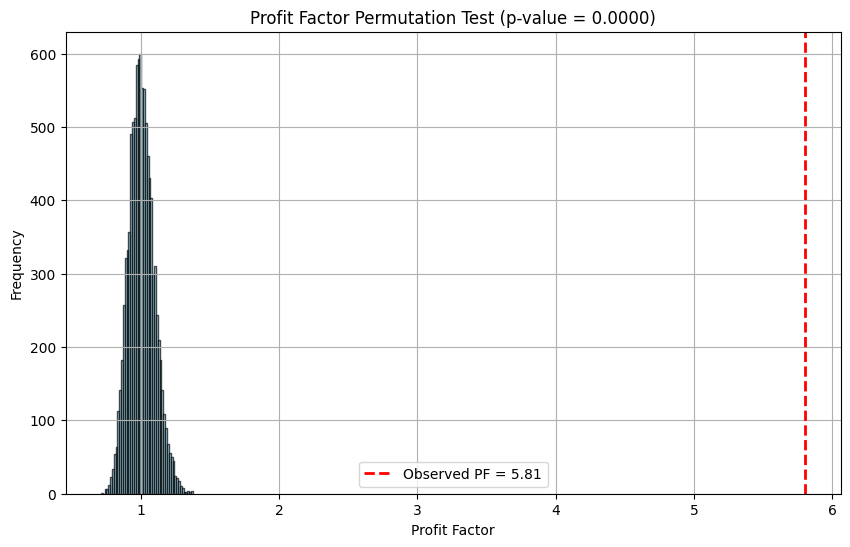


=== Profit Factor Permutation Test ===
Observed Profit Factor: 5.8070
Mean Permutation Profit Factor: 1.0049
P-value: 0.0000
Result: The observed profit factor is statistically significant (p < 0.05)


In [8]:
# Run the walk-forward analysis
oos_results, profit_factor_pvalue = run_walkforward_analysis(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    use_trailing_stop=True,
    exit_bars=30
)